 # Flood Relief Aid Prediction: Medical Camps Forecasting
                   


**Objective:**

To collect and clean historical flood data (1970–2012) from the official sites of pakistan. 
To Predict the number of medical camps required in flood-affected regions using socio-demographic and damage-related features by training a regression model.
To evaluate  model performance.

**Dataset Description**
- **Source:** Self-collected regional flood data (PDMA and local sources)
- **Target:** medical_camps
- **Features used in model:**
    - total_population
    - village_affected
    - persons_affected
    - area_affected
    - cropped_area_affected
    - houses_damaged


**Import the Libraries:**

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
sns.set(style="whitegrid")
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib


Load The Dataset:


In [2]:
URL = "https://raw.githubusercontent.com/MilhanZahid/Flood-Medical-Aid-Predictor/main/Flood%20Project%20Dataset.xlsx"
df = pd.read_excel(URL)
df.columns = df.columns.str.strip()
df.head()


,District,Tehsil,year,total population,Village Affected,Persons Affected,Area Affected,Cropped Area Affected,Houses Damaged,Shelter tents,Medical camps,hygiene kit
0,Sialkot,Shakargarh,1975,295632.0,258,20739,20739,14026,5193,3457,104,8296
1,Sialkot,Narowal,1975,834501.0,250,182363,182363,63390,6930,30403,100,72945
2,Sialkot,Pasrur,1975,612745.0,175,10227,10227,10552,711,1705,71,4091
3,Sialkot,Daska,1975,502318.0,91,30000,30000,5000,541,4930,37,12000
4,Sialkot,Sialkot,1975,1509424.0,49,33265,33265,4099,277,5550,20,13306


**Dataset Dimensions:**

In [3]:
df.shape

(2656, 12)

**Summary of Dataset:**


In [4]:
df.info

<bound method DataFrame.info of        District       Tehsil  year  total population Village Affected  \
0      Sialkot   Shakargarh   1975          295632.0              258   
1      Sialkot      Narowal   1975          834501.0              250   
2      Sialkot       Pasrur   1975          612745.0              175   
3      Sialkot        Daska   1975          502318.0               91   
4      Sialkot      Sialkot   1975         1509424.0               49   
...         ...          ...   ...               ...              ...   
2651  Pakpattan    Pakpattan  2011          458407.0               10   
2652  Pakpattan    Pakpattan  2011          467546.0               10   
2653    Chakwal      Chakwal  2011          321234.0                5   
2654    Chakwal      Chakwal  2011          332038.0                5   
2655    Chakwal      Chakwal  2011          322726.0                5   

     Persons Affected Area Affected Cropped Area Affected Houses Damaged  \
0              

In [5]:
df.dtypes

District                  object
Tehsil                    object
year                       int64
total population         float64
Village Affected          object
Persons Affected          object
Area Affected             object
Cropped Area Affected     object
Houses Damaged            object
Shelter tents             object
Medical camps             object
hygiene kit               object
dtype: object

In [ ]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print(df.columns.tolist())



['district', 'tehsil', 'year', 'total_population', 'village_affected', 'persons_affected', 'area_affected', 'cropped_area_affected', 'houses_damaged', 'shelter_tents', 'medical_camps', 'hygiene_kit']


**Removing Duplicates:**

In [7]:
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

Duplicates removed.


**Fixing the datatypes of the columns:**

Most of the columns were in obj datatype, converting them back to float.

In [8]:
numeric_cols = [
    'year',
    'total_population',
    'village_affected',
    'persons_affected',
    'area_affected',
    'cropped_area_affected',
    'houses_damaged',
    'shelter_tents',
    'medical_camps',
    'hygiene_kit'
]


In [9]:
for col in numeric_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.replace(',', '', regex=False)
        .str.replace('%', '', regex=False)
    )



In [10]:
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [11]:
df.dtypes

district                  object
tehsil                    object
year                       int64
total_population         float64
village_affected         float64
persons_affected         float64
area_affected            float64
cropped_area_affected    float64
houses_damaged           float64
shelter_tents            float64
medical_camps            float64
hygiene_kit              float64
dtype: object

**Removing Unnecessary columns:**

Removing the columns that are unneceesary in model training, and do not cause any useful pattern

In [12]:
df = df.drop(columns=['Shelter tents', 'hygiene kit', 'year', 'District', 'Tehsil'], errors='ignore')
print("Remaining columns in dataset:")
print(df.columns)


Remaining columns in dataset:
Index(['district', 'tehsil', 'total_population', 'village_affected',
       'persons_affected', 'area_affected', 'cropped_area_affected',
       'houses_damaged', 'shelter_tents', 'medical_camps', 'hygiene_kit'],
      dtype='object')


**Handling missing and null values of the dataset per feature study:**


Handling each column's missing and null individually..

count    2.112000e+03
mean     1.026395e+06
std      9.090299e+05
min      1.181620e+05
25%      4.562288e+05
50%      7.843210e+05
75%      1.343106e+06
max      7.378090e+06
Name: total_population, dtype: float64
Missing values: 66


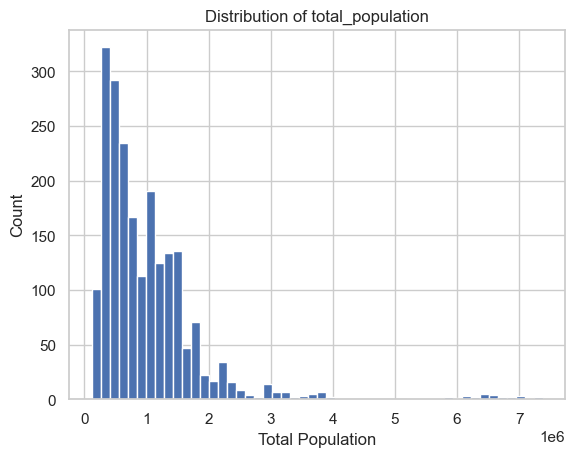

In [13]:
print(df['total_population'].describe())
print("Missing values:", df['total_population'].isna().sum())
plt.hist(df['total_population'], bins=50)
plt.title("Distribution of total_population")
plt.xlabel("Total Population")
plt.ylabel("Count")
plt.show()


In [14]:
df['total_population'].fillna(df['total_population'].median(), inplace=True)


C:\Users\User\AppData\Local\Temp\ipykernel_11860\1814529898.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_population'].fillna(df['total_population'].median(), inplace=True)


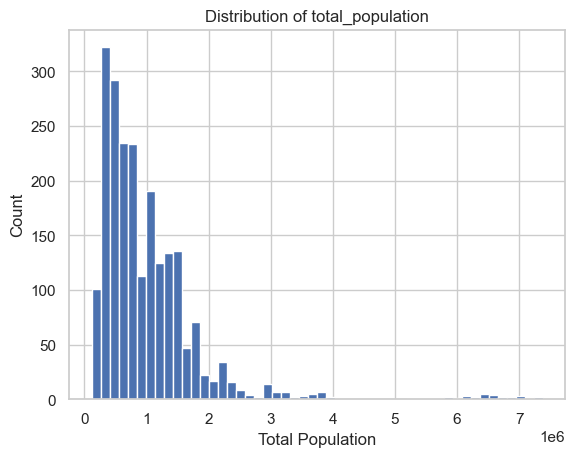

In [15]:
plt.hist(df['total_population'], bins=50)
plt.title("Distribution of total_population")
plt.xlabel("Total Population")
plt.ylabel("Count")
plt.show()


In [16]:
print(df['village_affected'].describe())
print("Missing values:", df['village_affected'].isna().sum())


count    1.674000e+03
mean     4.165809e+03
std      5.983721e+04
min      0.000000e+00
25%      2.600000e+01
50%      7.500000e+01
75%      1.720000e+02
max      1.246161e+06
Name: village_affected, dtype: float64
Missing values: 504


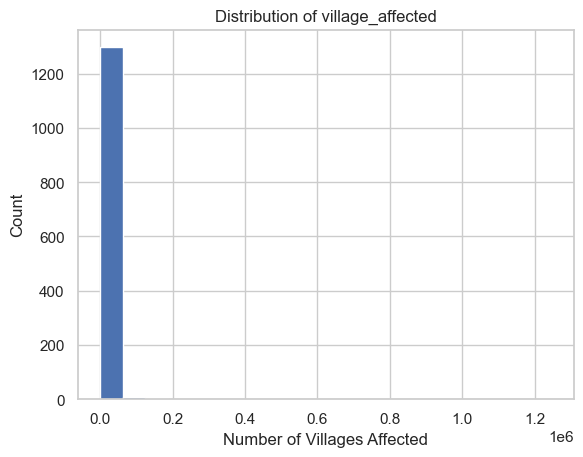

In [57]:
plt.hist(df['village_affected'], bins=20)
plt.title("Distribution of village_affected")
plt.xlabel("Number of Villages Affected")
plt.ylabel("Count")
plt.show()


In [19]:
median_val = df['village_affected'].median()
df['village_affected'].fillna(median_val, inplace=True)


C:\Users\User\AppData\Local\Temp\ipykernel_11860\3467464720.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['village_affected'].fillna(median_val, inplace=True)


In [20]:
print(df['persons_affected'].describe())
print("Missing values:", df['persons_affected'].isna().sum())


count    1.356000e+03
mean     7.860475e+04
std      2.358536e+05
min      0.000000e+00
25%      2.191000e+03
50%      1.572850e+04
75%      7.359300e+04
max      4.034563e+06
Name: persons_affected, dtype: float64
Missing values: 822


In [21]:
missing_mask = df['persons_affected'].isna()
low = int(df['persons_affected'].quantile(0.25))
high = int(df['persons_affected'].quantile(0.75))


df.loc[missing_mask, 'persons_affected'] = np.random.randint(
    low, high, size=missing_mask.sum()
)


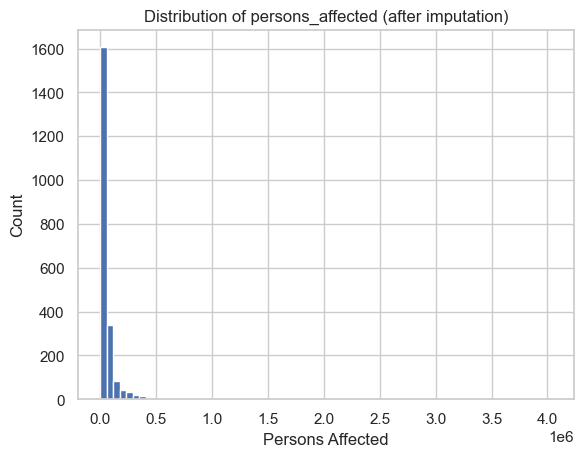

In [22]:
plt.hist(df['persons_affected'], bins=70)
plt.title("Distribution of persons_affected (after imputation)")
plt.xlabel("Persons Affected")
plt.ylabel("Count")
plt.show()


In [23]:
df = df.drop(columns=[
    'persons_affected_log',
    'village_affected_missing',
    'village_affected_log'
], errors='ignore')


In [24]:
df['area_affected'].describe()



count    1.551000e+03
mean     8.878219e+04
std      1.363415e+05
min      0.000000e+00
25%      7.227000e+03
50%      3.571700e+04
75%      1.195675e+05
max      1.153313e+06
Name: area_affected, dtype: float64

In [25]:

q1 = df['area_affected'].quantile(0.25)
q3 = df['area_affected'].quantile(0.75)

mask = df['area_affected'].isna()
df.loc[mask, 'area_affected'] = np.random.uniform(q1, q3, size=mask.sum())


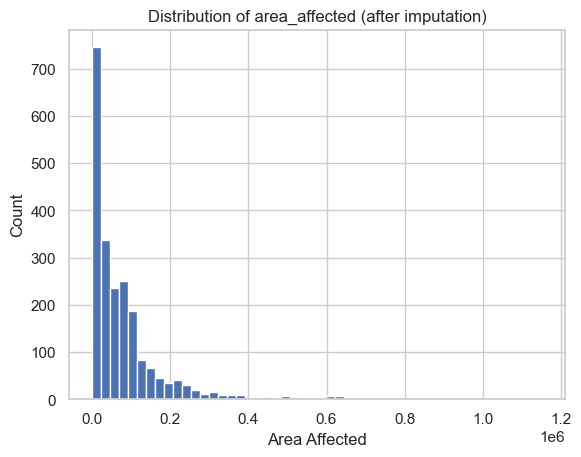

In [26]:
plt.hist(df['area_affected'], bins=50)
plt.title("Distribution of area_affected (after imputation)")
plt.xlabel("Area Affected")
plt.ylabel("Count")
plt.show()


In [27]:
df['cropped_area_affected'].describe()


count      1513.000000
mean      34249.025116
std       71689.718347
min           0.000000
25%        1627.000000
50%        9872.000000
75%       39459.000000
max      688393.000000
Name: cropped_area_affected, dtype: float64

In [28]:
q1 = df['cropped_area_affected'].quantile(0.25)
q3 = df['cropped_area_affected'].quantile(0.75)

mask = df['cropped_area_affected'].isna()
df.loc[mask, 'cropped_area_affected'] = np.random.uniform(q1, q3, size=mask.sum())


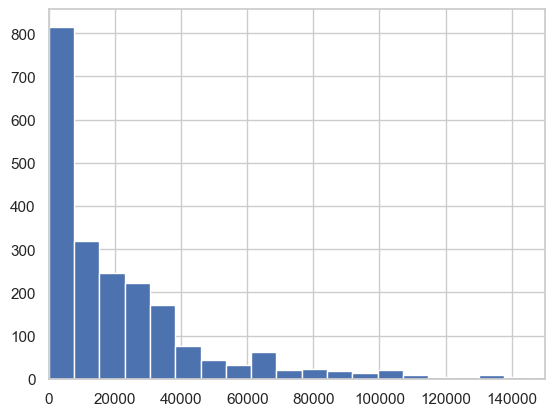

In [29]:
plt.hist(df['cropped_area_affected'], bins=90)
plt.xlim(0, 150000)
plt.show()



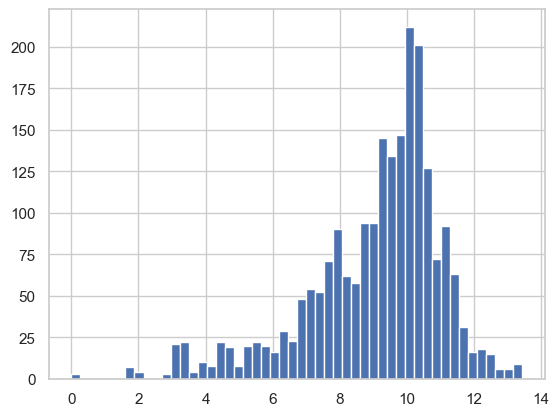

In [30]:
plt.hist(np.log1p(df['cropped_area_affected']), bins=50)
plt.show()


In [31]:
df['houses_damaged'].describe()
df['houses_damaged'].isna().sum()


np.int64(590)

In [32]:
np.random.seed(42)
q25 = df['houses_damaged'].quantile(0.25)
q75 = df['houses_damaged'].quantile(0.75)

mask = df['houses_damaged'].isna()
n_missing = mask.sum()

df.loc[mask, 'houses_damaged'] = np.random.uniform(low=q25, high=q75, size=n_missing)


In [33]:
df['shelter_tents'].describe
df['shelter_tents'].isnull().sum()

np.int64(577)

In [34]:
df.isnull().sum()

district                   3
tehsil                     0
total_population           0
village_affected           0
persons_affected           0
area_affected              0
cropped_area_affected      0
houses_damaged             0
shelter_tents            577
medical_camps            335
hygiene_kit              552
dtype: int64

**zeros:**

In [35]:
df.replace('-', 0, inplace=True)
feature_cols = [
    'total_population',
    'village_affected',
    'persons_affected',
    'area_affected',
    'cropped_area_affected',
    'houses_damaged'
]

zero_counts = (df[feature_cols] == 0).sum()
print(zero_counts)


total_population           0
village_affected           3
persons_affected           3
area_affected              3
cropped_area_affected      3
houses_damaged           249
dtype: int64


In [58]:
np.random.seed(42)

feature_cols_with_zeros = [
    'village_affected',
    'persons_affected',
    'area_affected',
    'cropped_area_affected',
    'houses_damaged'
]

for col in feature_cols_with_zeros:
    zero_mask = df[col] == 0
    n_zeros = zero_mask.sum()

    if n_zeros == 0:
        continue

    q1 = df.loc[df[col] != 0, col].quantile(0.25)
    q3 = df.loc[df[col] != 0, col].quantile(0.75)

    df.loc[zero_mask, col] = np.random.uniform(
        low=q1,
        high=q3,
        size=n_zeros
    )



In [37]:
targets = ['shelter_tents', 'medical_camps', 'hygiene_kit']

missing_rows = df[targets].isna().any(axis=1)

print("Rows with at least one missing target:", missing_rows.sum())

print("Rows remaining after dropping:", df.shape[0] - missing_rows.sum())


Rows with at least one missing target: 866
Rows remaining after dropping: 1312


Rwmoving Rows missing target values:

In [38]:
df = df.loc[~missing_rows].copy()
print(df[targets].isna().sum())

shelter_tents    0
medical_camps    0
hygiene_kit      0
dtype: int64


Graphs:


Distribution of Numeric Features:

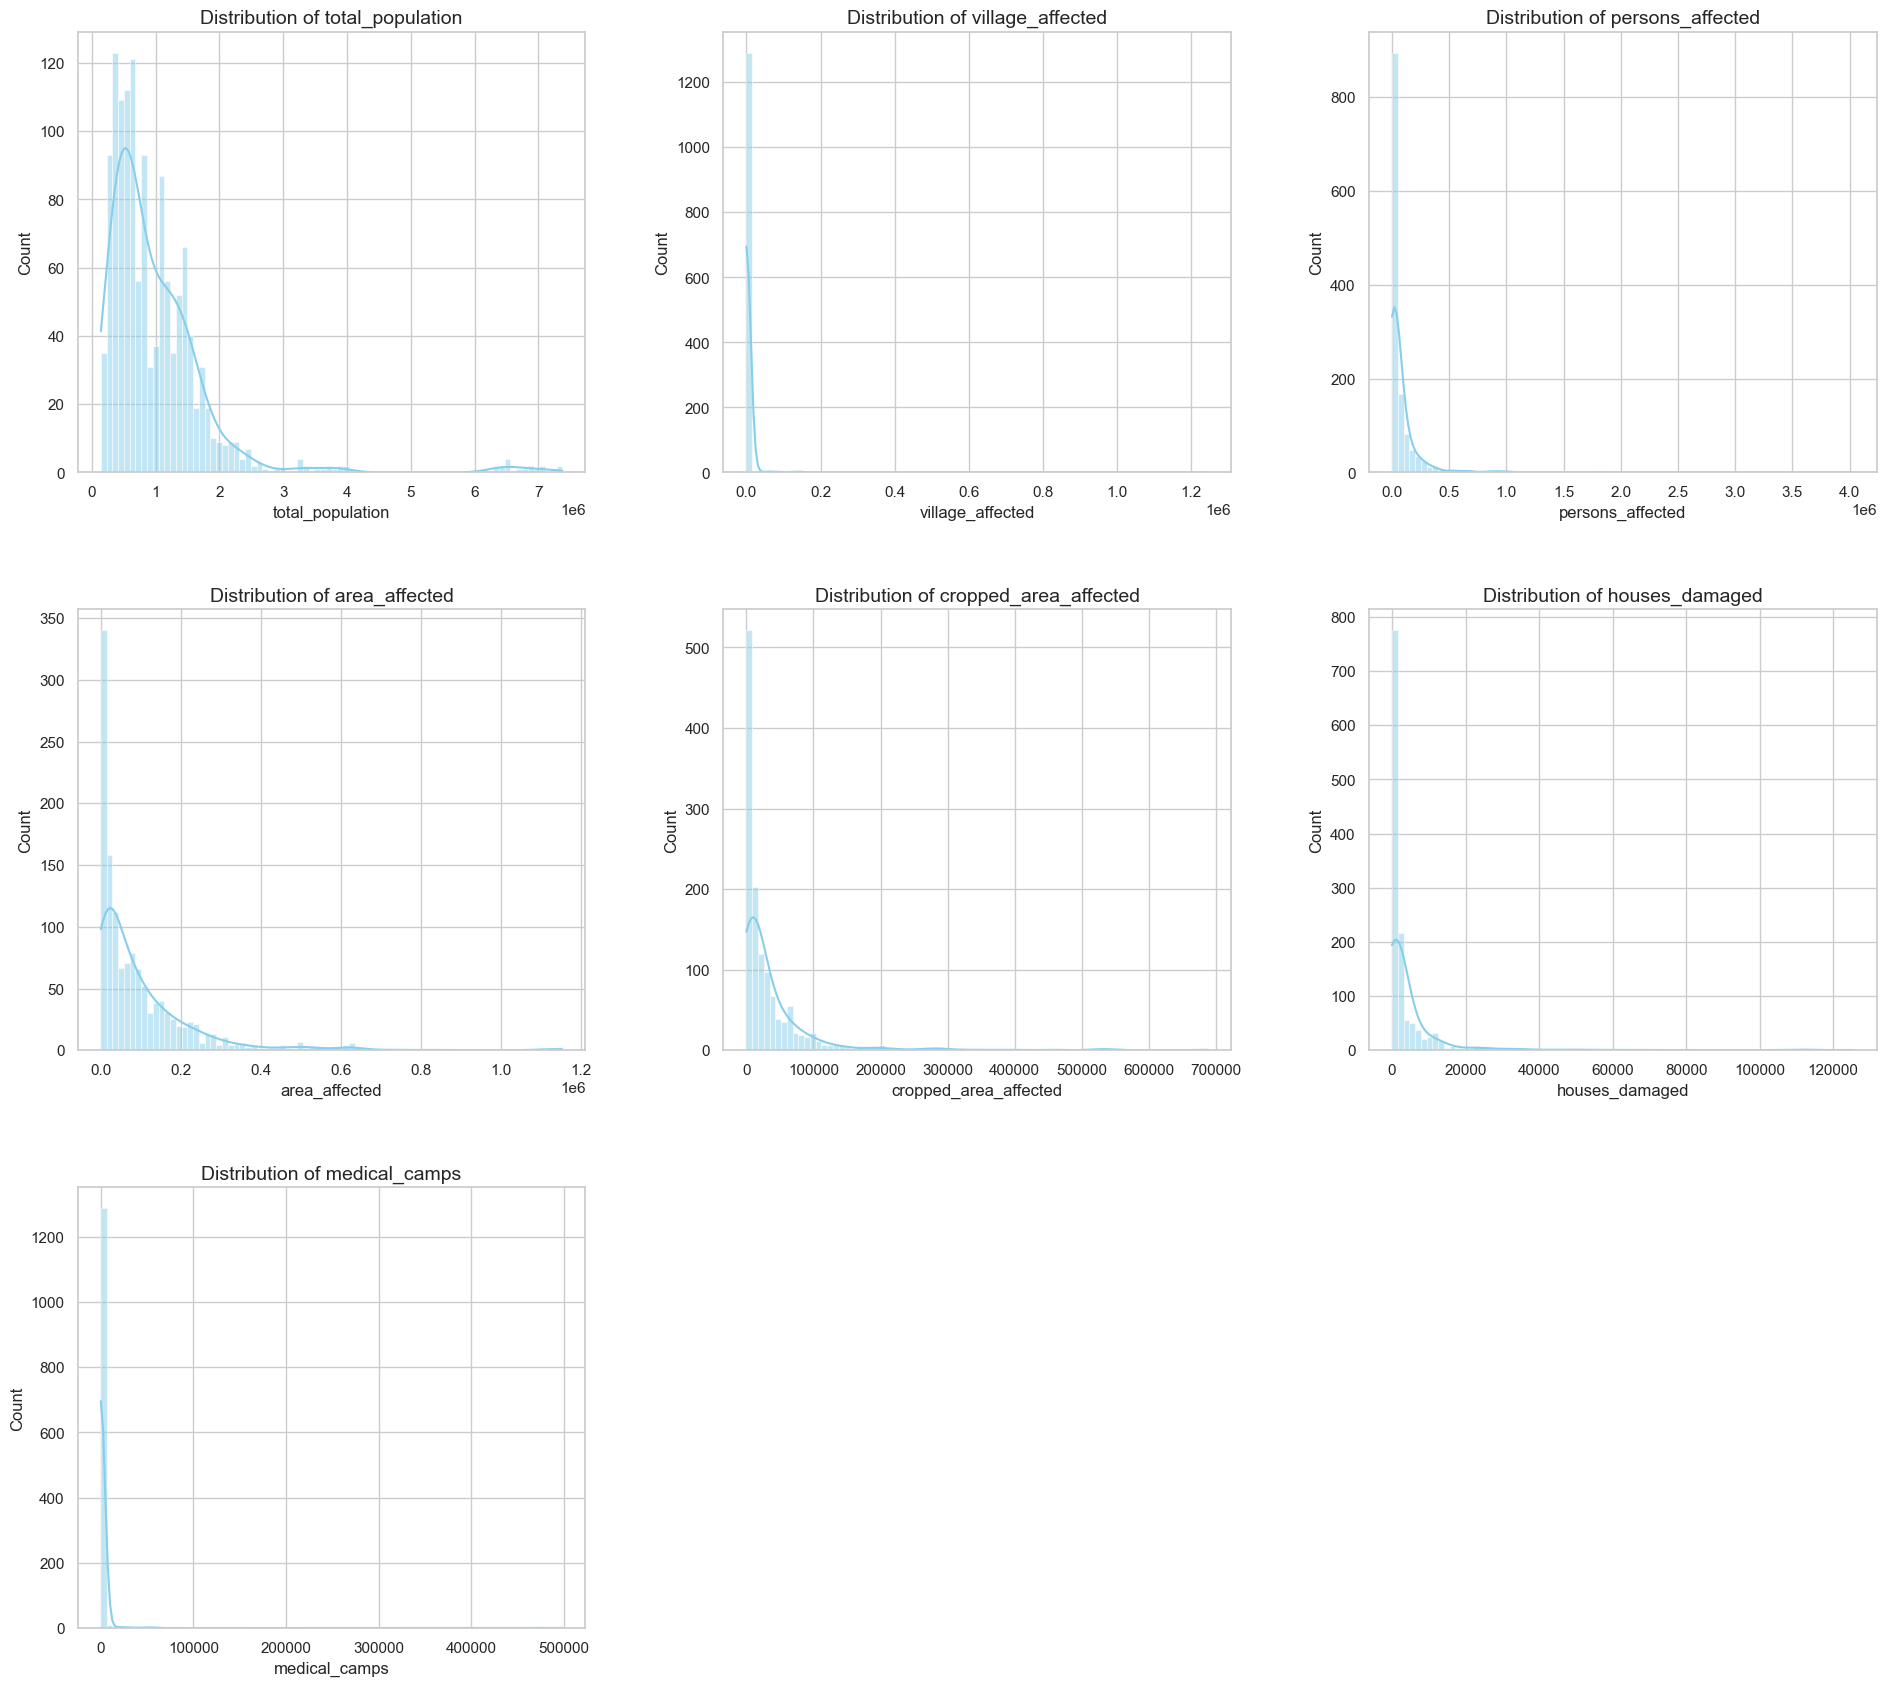

In [39]:
num_cols = ['total_population', 'village_affected', 'persons_affected',
            'area_affected', 'cropped_area_affected', 'houses_damaged',
             'medical_camps']

plt.figure(figsize=(20, 18))  

rows = 3
cols = 3

for i, col in enumerate(num_cols):
    plt.subplot(rows, cols, i+1)
    sns.histplot(df[col], bins=80, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)

plt.tight_layout(pad=4.0)  
plt.show()


Correlation Heatmap:

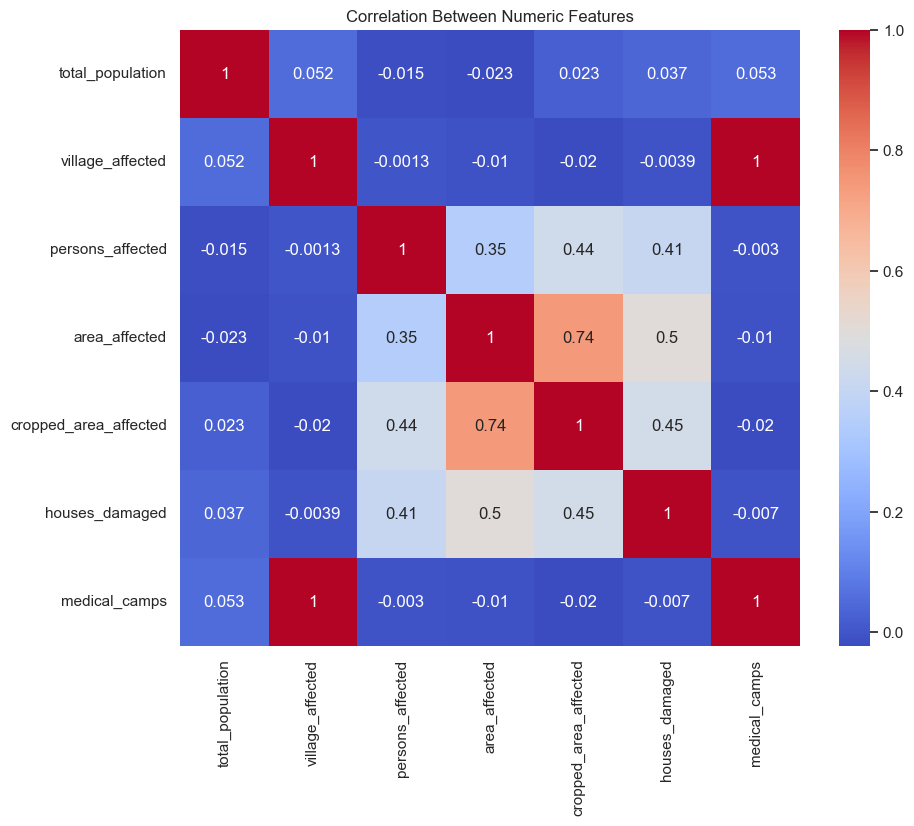

In [40]:
plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Between Numeric Features")
plt.show()


Confirms domain logic since some features dominate prediction, Others contribute weakly or conditionally

Persons Affected per  District:

C:\Users\User\AppData\Local\Temp\ipykernel_11860\4282380263.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='district', y='persons_affected', data=agg, palette='tab20')


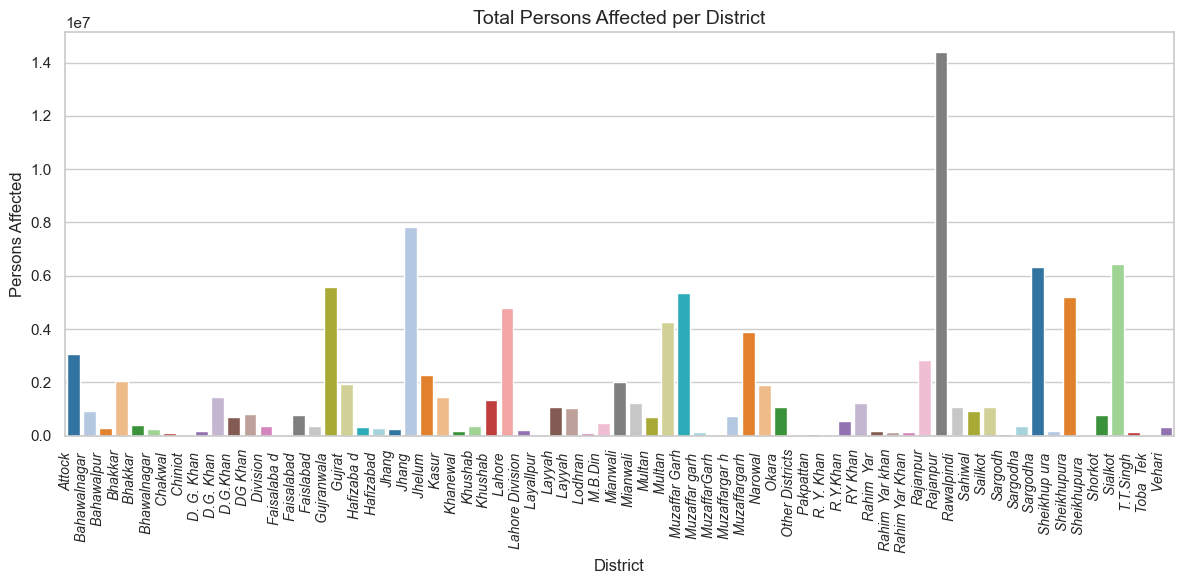

In [41]:
agg = df.groupby('district')[['total_population','persons_affected']].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='district', y='persons_affected', data=agg, palette='tab20')

plt.xticks(rotation=90, ha='right', fontsize=10, fontstyle='italic')

plt.title("Total Persons Affected per District", fontsize=14)
plt.ylabel("Persons Affected", fontsize=12)
plt.xlabel("District", fontsize=12)
plt.tight_layout()
plt.show()


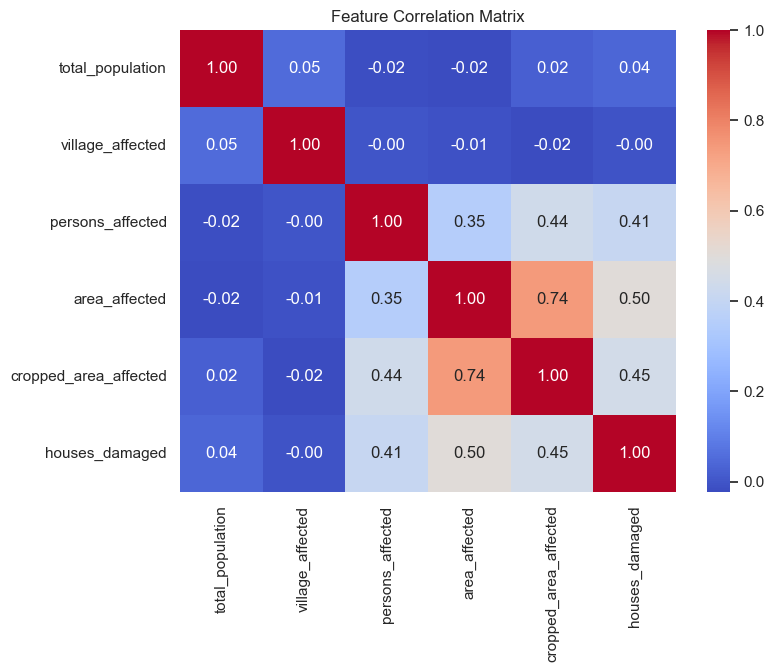

In [45]:
plt.figure(figsize=(8,6))
sns.heatmap(df[
    [
        'total_population',
        'village_affected',
        'persons_affected',
        'area_affected',
        'cropped_area_affected',
        'houses_damaged'
    ]
].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


In [46]:
df

,district,tehsil,total_population,village_affected,persons_affected,area_affected,cropped_area_affected,houses_damaged,shelter_tents,medical_camps,hygiene_kit
0,Sialkot,Shakargarh,295632.0,258.000000,20739.000000,20739.000000,14026.000000,5193.0,3457.0,104.0,8296.0
1,Sialkot,Narowal,834501.0,250.000000,182363.000000,182363.000000,63390.000000,6930.0,30403.0,100.0,72945.0
2,Sialkot,Pasrur,612745.0,175.000000,10227.000000,10227.000000,10552.000000,711.0,1705.0,71.0,4091.0
3,Sialkot,Daska,502318.0,91.000000,30000.000000,30000.000000,5000.000000,541.0,4930.0,37.0,12000.0
4,Sialkot,Sialkot,1509424.0,49.000000,33265.000000,33265.000000,4099.000000,277.0,5550.0,20.0,13306.0
...,...,...,...,...,...,...,...,...,...,...,...
2580,Multan,Multan,1507916.0,62.000000,238408.000000,63633.000000,44659.000000,2275.0,377.0,26.0,95366.0
2582,Sargodha,Sargodha,1007017.0,122.515002,127521.000000,107719.000000,166993.000000,4043.0,674.0,0.0,51011.0
2583,Sargodha,Sargodha,963805.0,102.611449,126508.000000,107222.000000,163224.000000,3972.0,662.0,0.0,50606.0
2585,Other Districts,Other Districts,1190658.0,28.000000,14471.362356,88801.948799,3592.269813,4153.0,692.0,10.0,0.0


**Outliers:**

**Training the Model:**

In [47]:
FEATURES = [
    'total_population',
    'village_affected',
    'persons_affected',
    'area_affected',
    'cropped_area_affected',
    'houses_damaged'
]

TARGET = 'medical_camps'

X = df[FEATURES]
y = np.log1p(df[TARGET]) 

we log transformed the target since the target was heavily right-skewed , large flood events dominated error metrics

Log transformation reduced the dominance of extreme flood events and allowed the model to learn patterns across both small and large disasters.

**Train-Test Split:**

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [49]:
low, high = y_train.quantile([0.01, 0.99])
y_train = y_train.clip(low, high)


Clipped extreme target values using the 1st and 99th percentiles to reduce the influence of rare catastrophic floods, improving model stability and generalization without removing data.

Applied clipping only on the training target, not the test set, to prevent data leakage and preserve unbiased evaluation.

**Baseline Model Training:**

In [50]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,          
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)



,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples

Established a baseline to understand how much improvement tuning could realistically provide.

**Chose RandomForest because:**
Handles non-linear relationships, 
Robust to outliers, 
No feature scaling required, 
Performs well on small-to-medium datasets, 
Provides feature importance.

RandomForest provided the best balance between performance, interpretability, and robustness for disaster response prediction.

In [ ]:
y_train_pred = rf.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))  # manual RMSE

print(f"{TARGET} TRAIN R²: {train_r2:.4f}")
print(f"{TARGET} TRAIN MAE: {train_mae:.4f}")
print(f"{TARGET} TRAIN RMSE: {train_rmse:.4f}")

medical_camps TRAIN R²: 0.8305
medical_camps TRAIN MAE: 0.2886
medical_camps TRAIN RMSE: 0.6146


In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2 = cross_val_score(rf, X_train, y_train, scoring='r2', cv=cv)
cv_mae = cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv)
cv_rmse = cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)

print(f"{TARGET} CV R² mean: {cv_r2.mean():.4f}, std: {cv_r2.std():.4f}")
print(f"{TARGET} CV MAE mean: {(-cv_mae).mean():.4f}, std: {cv_mae.std():.4f}")
print(f"{TARGET} CV RMSE mean: {(-cv_rmse).mean():.4f}, std: {cv_rmse.std():.4f}")


medical_camps CV R² mean: 0.7051, std: 0.0858
medical_camps CV MAE mean: 0.3945, std: 0.0388
medical_camps CV RMSE mean: 0.7960, std: 0.1262


**RandomizedSearch:**

Used RandomizedSearchCV, which is a method that searches across a defined set of hyperparameter values randomly for a fixed number of iterations. Unlike a full grid search, which tries every possible combination,

 RandomizedSearchCV is computationally more efficient, especially for large parameter grids, while still covering a wide range of possibilities. It also uses cross-validation internally to ensure that the parameter choices generalize well across different subsets of the data, reducing the risk of overfitting.

In [ ]:
param_dist = {
    'n_estimators': [300, 500, 800, 1000],
    'max_depth': [6, 8, 10, 12],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [3, 5, 10],
    'max_features': ['sqrt', 0.6, 0.8]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error', 
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [6, 8, ...], 'max_features': ['sqrt', 0.6, ...], 'min_samples_leaf': [3, 5, ...], 'min_samples_split': [5, 10, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",30
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategie

In [60]:
best_rf = random_search.best_estimator_
y_train_pred = best_rf.predict(X_train)
y_test_pred  = best_rf.predict(X_test)


Evaluating the model on both training and test datasets using MAE, RMSE, and R² metrics.

In [ ]:
# Train metrics
train_mae  = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2   = r2_score(y_train, y_train_pred)

# Test metrics
test_mae  = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2   = r2_score(y_test, y_test_pred)

print("TRAIN RESULTS")
print(f"MAE : {train_mae:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"R²  : {train_r2:.4f}")

print("\nTEST RESULTS")
print(f"MAE : {test_mae:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²  : {test_r2:.4f}")


TRAIN RESULTS
MAE : 0.2885
RMSE: 0.6182
R²  : 0.8285

TEST RESULTS
MAE : 0.3610
RMSE: 0.6858
R²  : 0.7573


The Random Forest model was tuned using RandomizedSearchCV with internal 5-fold cross-validation. The test set metrics (MAE, RMSE, R²) are therefore reliable, and no additional cross-validation is needed.


**This pipeline demonstrates how machine learning can support disaster preparedness by translating flood severity data into actionable medical planning insights.**

In [68]:

joblib.dump(best_rf, "Flood_Medical_Aid_rf_model.pkl")

# loaded_model = joblib.load("Flood_Medical_Aid_rf_model.pkl")


['Flood_Medical_Aid_rf_model.pkl']